# Correlation matrices visualization of CIFAR-100 models

In [ ]:
!export PYTHONPATH="/home/fabien/Documents/project/2d/mdistiller:$PYTHONPATH"

In [6]:
import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn
from collections import OrderedDict

from mdistiller.models import cifar_model_dict
from mdistiller.dataset import get_dataset
from mdistiller.engine.utils import load_checkpoint
from mdistiller.engine.cfg import CFG as cfg

In [8]:
def load_model(tea, stu, mpath):
    cfg.defrost()
    cfg.DISTILLER.STUDENT = stu
    cfg.DISTILLER.TEACHER = tea
    cfg.DATASET.TYPE = 'cifar100'
    cfg.freeze()
    train_loader, val_loader, num_data, num_classes = get_dataset(cfg)
    model = cifar_model_dict[cfg.DISTILLER.STUDENT][0](num_classes=num_classes)
    fully_state = load_checkpoint(mpath)["model"]
    student_weights = OrderedDict()
    teacher_weights = OrderedDict()

    for key, value in fully_state.items():
        # 检查权重键是否包含 "student"
        if 'student' in key:
            key = key.replace("module.student.", "")
            student_weights[key] = value
        if 'teacher' in key:
            key = key.replace("module.teacher.", "")
            teacher_weights[key] = value
    # model.load_state_dict(load_checkpoint(mpath)["model"])
    # tea_model = cifar_model_dict[cfg.DISTILLER.TEACHER][0](num_classes=num_classes)
    # tea_model.load_state_dict(load_checkpoint(cifar_model_dict[cfg.DISTILLER.TEACHER][1])["model"])
    model.load_state_dict(student_weights)
    tea_model = cifar_model_dict[cfg.DISTILLER.TEACHER][0](num_classes=num_classes)
    tea_model.load_state_dict(teacher_weights)
    print("load {} successfully!".format(mpath))
    return model, tea_model, val_loader

In [9]:
# visualize the difference between the teacher's output logits and the student's
def get_output_metric(model, val_loader, num_classes=100):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for i, (data, labels) in tqdm(enumerate(val_loader)):
            outputs, _ = model(data)
            preds = outputs
            all_preds.append(preds.data.cpu().numpy())
            all_labels.append(labels.data.cpu().numpy())
    
    all_preds = np.concatenate(all_preds, 0)
    all_labels = np.concatenate(all_labels, 0)
    matrix = np.zeros((num_classes, num_classes))
    cnt = np.zeros((num_classes, 1))
    for p, l in zip(all_preds, all_labels):
        cnt[l, 0] += 1
        matrix[l] += p
    matrix /= cnt
    return matrix

def get_tea_stu_diff(tea, stu, mpath, max_diff):
    cfg.defrost()
    cfg.DISTILLER.STUDENT = stu
    cfg.DISTILLER.TEACHER = tea
    cfg.DATASET.TYPE = 'cifar100'
    cfg.freeze()
    train_loader, val_loader, num_data, num_classes = get_dataset(cfg)
    model = cifar_model_dict[cfg.DISTILLER.STUDENT][0](num_classes=num_classes)
    # model.load_state_dict(load_checkpoint(mpath)["model"])
    tea_model = cifar_model_dict[cfg.DISTILLER.TEACHER][0](num_classes=num_classes)
    tea_model.load_state_dict(load_checkpoint(cifar_model_dict[cfg.DISTILLER.TEACHER][1])["model"])
    model, tea_model, val_loader = load_model(tea, stu, mpath)
    print("load model successfully!")
    ms = get_output_metric(model, val_loader)
    mt = get_output_metric(tea_model, val_loader)
    diff = np.abs((ms - mt)) / max_diff
    for i in range(100):
        diff[i, i] = 0
    print('max(diff):', diff.max())
    print('mean(diff):', diff.mean())
    seaborn.heatmap(diff, vmin=0, vmax=1.0, cmap="PuBuGn")
    plt.show()

In [10]:
# set a common max-value of the difference for fair comparsion between different methods
MAX_DIFF = 3.0

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
load /home/fabien/Documents/project/2d/mdistiller/tools/output/final/324_84/kd_324_84/best successfully!
load model successfully!


157it [00:09, 16.97it/s]
157it [00:42,  3.69it/s]


max(diff): 0.8513467212518059
mean(diff): 0.09226480989597481


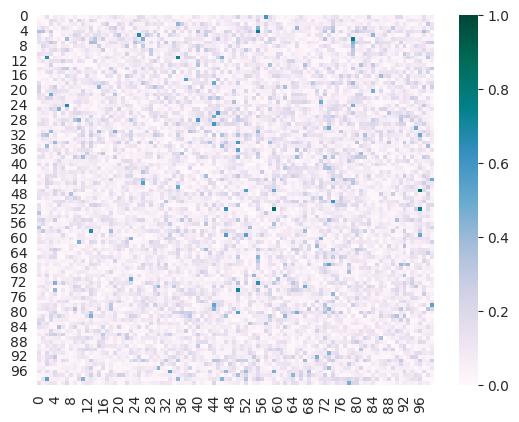

In [11]:
# KD baseline
mpath = "/home/fabien/Documents/project/2d/mdistiller/tools/output/final/324_84/kd_324_84/best"
get_tea_stu_diff("resnet32x4", "resnet8x4", mpath, MAX_DIFF)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
load /home/fabien/Documents/project/2d/mdistiller/tools/output/final/324_84/fitnet_324_84/best successfully!
load model successfully!


157it [00:09, 17.02it/s]
157it [00:46,  3.39it/s]


max(diff): 2.804025498777628
mean(diff): 0.45108727381816344


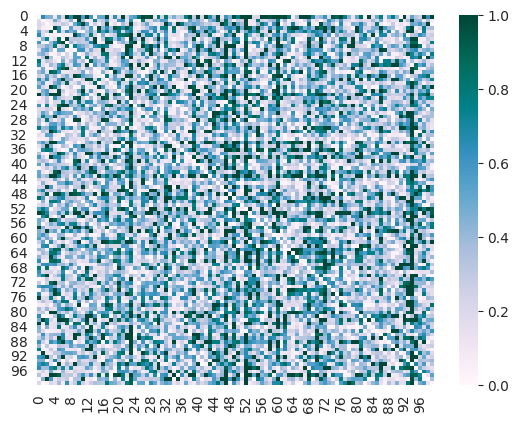

In [13]:
# FitNet
mpath = "/home/fabien/Documents/project/2d/mdistiller/tools/output/final/324_84/fitnet_324_84/best"
get_tea_stu_diff("resnet32x4", "resnet8x4", mpath, MAX_DIFF)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
load /home/fabien/Documents/project/2d/mdistiller/tools/output/final/324_84/mlkd_324_84/best successfully!
load model successfully!


157it [00:09, 16.43it/s]
157it [00:45,  3.45it/s]


max(diff): 0.8107620830833913
mean(diff): 0.07867803698266018


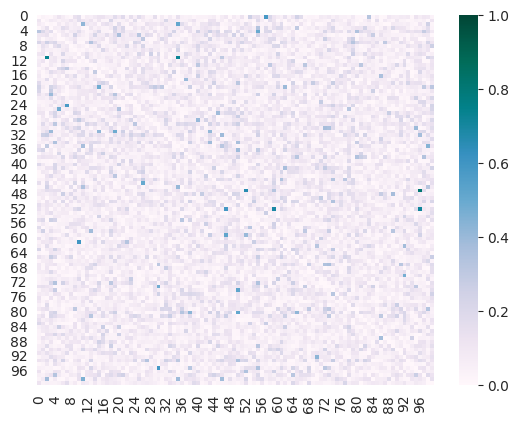

In [14]:
# MLKD
mpath = "/home/fabien/Documents/project/2d/mdistiller/tools/output/final/324_84/mlkd_324_84/best"
get_tea_stu_diff("resnet32x4", "resnet8x4", mpath, MAX_DIFF)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
load /home/fabien/Documents/project/2d/mdistiller/tools/output/final/324_84/UniKD_78.18/epoch_480 successfully!
load model successfully!


157it [00:09, 16.92it/s]
157it [00:52,  3.01it/s]


max(diff): 0.6800015960882106
mean(diff): 0.08745598402711767


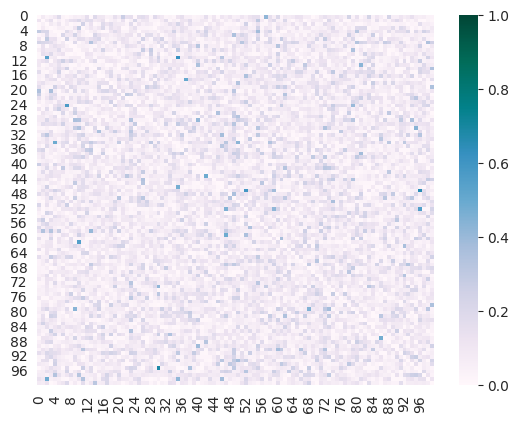

In [17]:
# Ours
mpath = "/home/fabien/Documents/project/2d/mdistiller/tools/output/final/324_84/UniKD_78.18/epoch_480"
get_tea_stu_diff("resnet32x4", "resnet8x4", mpath, MAX_DIFF)